20211003 1609
复现[fastai教程](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb)中，预测过山车的车速的例子


目的：通过复现fastai教程中的预测过山车的车速的例子，深入理解机器学习的原理和步骤

案例描述

我想要运用机器学习这种计算机技术，解决下面的问题：

游乐园的过山车在上坡、下坡的时候，在不同的时刻，会有不同的速度，
我在游乐园中，通过测速仪器测量一段时间内的过山车的车速，记录成时间以及对应的车速，这样的tuple，
例如发车后第1秒的车速是1m/s, 第2秒的车速是2m/s,,,,

我想要获得一个程序或函数，它接收时间，例如第10秒，然后它能求出该时刻对应的车速。

严格的机器学习操作，应该要有训练数据集和验证数据集，生成模型程序的过程中是不能接触到验证数据集的。

但是我本节课，主要是想理解机器学习的训练过程。
所以我会集中精力把训练过程给做好。然后再考虑验证模型的操作怎么做。

我发现，fastai教程中有个bug，就是在过山车这个案例中，没有讲验证数据集的事。 

In [ ]:
# 在服务器上安装fastbook包
!pip install -Uqq fastbook

# 导入模块
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys') # 这好像是一句跟matplotlib底层相关的代码

这个过山车车速的例子，主要是为了阐明，在训练模型的过程中，如何运用“找loss函数的最小值”这样的技术。 

这节课的主要目的，就是训练一个模型，它能接收时间输入值，然后求得该时刻对应的车速值。我会用一种粗略的方法来评估这个模型是否接近数据集的情况。

注意，这里没有用严谨的机器学习中，训练数据集与验证数据集的标准操作流程。

我们采集过山车车速与时间关系的数据集，
这里用代码生成了一些数据。

我测量第0至20秒这段时间内，过山车的车速，每一秒测得一个车速数值，第0秒有数值，第19秒有数值，第20秒没有数值。

首先，我用torch.arange()方法生成这些时刻的数据。

因为后面在预测车速值时，会对输入的时间数值做数学运算得到车速值，而且时间应该是可以取小数的，比如第1.5秒，所以我把这些时间的数据转成了float类型。

In [ ]:
observed_data_time = torch.arange(0,20).float()
print(f"{observed_data_time = }")

observed_data_time = tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])


然后，我需要这些时刻对应的车速的数据。
我没有实际去测量车速。我人为构造出来上面的每一个时刻对应的车速。

为了使这节课的实验的难度降低一些，我人为设定，车速是时间的二次方的关系式的结果值。

为了让车速数据贴近实际情况，根据初中、高中的二次函数的数学知识，这个“车速-时间"二次函数的曲线，应该开口向上，顶点位于平面直角坐标系的第1象限，也就是求得的车速值，应该都大于或等于0，随着时间从0开始增大，车速值会下降，这个模拟的是过山车上坡到最高处的过程，然后车速会上升，这个模拟的是过山车下坡的过程。

比如 speed = (time-10)**2

时间-车速的二次函数关系式曲线
![](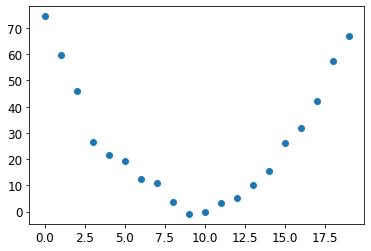%0A) 

因为现实中采集的数据不会与理论式子的计算值完全一样，为了模拟这种情况，
我用torch.randn()函数生成了一些随机数，它们本身就是float类型的数值，添加到二次函数的计算式中。 

[pytorch中的随机数起始种子的设定](https://pytorch.org/docs/stable/notes/randomness.html)

RNG: Random Number Generator 

In [ ]:
# 将涉及生成随机数的3个包中的随机数起始种子都给固定下来，
# 这样能使得下一次从头运行整个脚本时，生成的随机数跟这一次的是一样的。

# import torch
torch.manual_seed(0)

import random
random.seed(0)

import numpy as np
np.random.seed(0)


In [ ]:
# 设置生成采集数据的二次函数关系式中的参数
# a_in_observed_data_speed = 1
A = 1

# b_in_observed_data_speed = 10
B = 10

# c_in_observed_data_speed = 1
C = 1

In [ ]:
observed_data_speed = A*(observed_data_time-B)**2 + C + torch.randn(20)*3
# observed_data_speed = (observed_data_time-10)**2 + torch.randn(20)*1
# observed_data_speed = torch.randn(20)*3 + 0.75*(observed_data_time-9.5)**2 + 1
print(f"{observed_data_speed = }")

observed_data_speed = tensor([97.6225, 78.5429, 64.2483, 48.6984, 38.7965, 21.3347, 15.9759, 15.5590,  6.4043,  1.5269,  5.3310,  2.7981,  9.1681, 14.7590, 19.8389, 23.4690, 39.7955, 53.7770, 71.0149, 82.1612])


In [ ]:
# 生成随机数的函数的详细说明
torch.randn(20)
# 返回值是一个tensor，里面有20个数字，它们的平均值是0，方差是1.
# help(torch.randn)

tensor([ 0.4397,  0.1124,  0.6408,  0.4412,  0.2055, -0.4503, -0.5731, -0.5554,  0.5943,  1.5419,  0.5073, -0.5910, -1.3253,  0.1886, -0.0691, -0.4949, -1.4959, -0.1938,  0.4455,  1.3253])

用plt.scatter(x,y)函数，对时间与车速的数据，做散点图，初步看一下数据的情况。

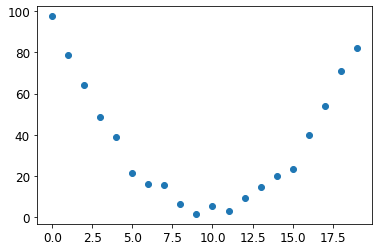

In [ ]:
plt.scatter(observed_data_time, observed_data_speed)
plt.show() 
# 无论写不写plt.show()函数，
# 上面的plt.scatter()函数执行后都会在jupyter notebook中显示出图片。
# 但是写plt.show()，则不会显示前面作图函数的返回值，
# 从读者的角度看，这样比较简洁美观

下面，我要开始进入机器学习的操作步骤。

首先是明确我的目的。

这里我的目的是，获得一个训练好的预测函数或称模型，用这个函数接收时间的输入值，能求得预测的车速值，预测的车速值与真实数据的车速值应该是比较接近的。

对于模型来说，我要有一个起点。

由于我现在知识有限，只能先试验性地做一些工作。
比如，我猜测，这个预测车速的模型，车速与时间是二次函数的关系。
其实我也可以猜测它们之间是三次函数、对数函数、指数函数，或者是一些奇怪的分段函数的关系。

这里为了降低本次课实验的难度，我直接猜成跟我上面模拟采集数据一样的二次函数关系，但是二次函数中具体的各个参数值，在我训练模型的时候是不知道的。

也就是说，我的模型的起点是
```
predicted_speed = a*(time**2) + b*(time) + c
```

在这种比较理想化的情境下，要解决的问题，就变成了，如何通过机器学习的策略或技术，找到最合适的a,b,c这3个参数值，使得上面的二次函数式子，最接近采集数据的情况。

这是一个回归问题，也就是把采集到的一个个的数据点，用数学式子解释。

直白地想的话，最终生成的可用的，预测模型函数是这样的
```
def predict_speed(time):
    return a1*(time**2) + b1*time + c1
```

为了后面更好地观察权重参数值在预测模型中的作用，我把二次函数式子写成下面的形式
```
def predict_speed(time):
    return a1*((time-b1)**2) + c1
```
二次函数曲线的顶点坐标为(b1,c1),开口朝上还是朝下，由a1的正负决定，开口是宽还是窄，由a1的绝对值的大小决定。

但是我在训练模型时（所谓训练模型，其实就是在调整改变模型中的参数的值），像a,b,c这样的参数是要被多次更新的。

所以在训练过程中，定义这个预测函数时，我要把a,b,c这样的参数也作为函数的可接收参数，这样可以在调用这个预测函数时，对函数的参数做改变。

In [ ]:
# 定义预测函数或称预测模型
# def predict_speed(time, parameters):
#     '''
#     parameters是rank-1 tensor, 里面有3个数字，
#     用的时候可以当做tuple来写赋值语句。
#     '''
#     a,b,c = parameters
#     return a*(time**2) + b*time + c

def predict_speed(time, parameters, A=A, B=B, C=C):
    '''
    parameters是rank-1 tensor, 里面有3个数字，
    用的时候可以当做tuple来写赋值语句。
    '''
    a,c = parameters
    return a*((time-B)**2) + c

In [ ]:
a,b,c = tensor([1,2,3])
print(f"{a = }")
print(f"{b = }")
print(f"{c = }")

a = tensor(1)
b = tensor(2)
c = tensor(3)


In [ ]:
# 其实python list 也能像tuple那样写赋值语句
d,e,f = [4,5,6]
print(f"{d = }")
print(f"{e = }")
print(f"{f = }")

d = 4
e = 5
f = 6


预测模型的轮廓我们勾勒好了，下面要把衡量预测模型有多好的方法给建立起来。

就是定义一个Loss函数，把某一个含有确定权重参数值的预测模型 对 输入数据的预测结果，与，输入数据的真实标签值，的差距给计算出来。

简化的描述是，计算 预测结果值，与，真实结果值，之间的差距。

一般是统计一堆数据的这种差距值，然后用统计学方法，求得一个代表值作为最终衡量的值。

对于连续型的数值，一般用square_root_of_mean_of_square_error方法。

说明：权重参数，在这里，就是指二次函数关系式中的系数a,b,c.

In [ ]:
# 定义Loss函数
def loss_square_root_of_mean_of_square_error(
        prediction_result, real_result
    ):
    '''
    用预测结果值减去真实结果值，求绝对值，取平均值。
    '''
    return (prediction_result-real_result).abs().mean()

# def loss_square_root_of_mean_of_square_error(
#         prediction_result, real_result
#     ):
#     '''
#     用预测结果值减去真实结果值，求平方，取平均值，然后求平方根。
#     '''
#     return ((prediction_result-real_result)**2).mean().sqrt()

下面开始机器学习的7个步骤 

#### 步骤1. 初始化预测模型的权重参数值 

对权重参数a,b,c，生成3个随机数作为他们的初始值。

.requires_grad_()表示，后面需要对在这些参数值处求梯度值，其实就是求Loss函数在这些权重参数值处的，预测结果值处的，Loss函数值的梯度值。

说明：所谓梯度值，其实就是某处的导数值，也就是该x处的，随x变化的y的变化情况。

In [ ]:
# parameters = torch.randn(3).requires_grad_()
parameters = torch.randn(2).requires_grad_()
print(f"{parameters = }")

parameters = tensor([-1.0297, -0.5008], requires_grad=True)


In [ ]:
# 拷贝保存一下，这个初始化的权重参数值
# 用.clone()拷贝，是独立性拷贝，后面分成完全独立的两个数据的变量
original_parameters = parameters.clone()
print(f"{original_parameters = }")

original_parameters = tensor([-1.0297, -0.5008], grad_fn=<CloneBackward>)


#### 步骤2. 调用当前具体的预测模型计算预测结果值

In [ ]:
prediction_result = predict_speed(
    time=observed_data_time, parameters=parameters
)
print(f"{prediction_result = }")

prediction_result = tensor([-103.4710,  -83.9066,  -66.4017,  -50.9562,  -37.5700,  -26.2433,  -16.9760,   -9.7681,   -4.6196,   -1.5305,   -0.5008,   -1.5305,   -4.6196,   -9.7681,  -16.9760,  -26.2433,  -37.5700,
         -50.9562,  -66.4017,  -83.9066], grad_fn=<AddBackward0>)


算出来，是与time tensor的20个数值对应的，20个speed数值。 

我写一个作图函数，在一个图中同时展示预测结果与真实结果，这样可以直观感受预测结果与真实结果之间的差距。 

In [ ]:
def show_prediction_and_real_results(
        prediction_result, 
        time=observed_data_time,
        observed_data_speed=observed_data_speed
    ):
    '''
    在一个图中同时展示预测结果与真实结果
    '''
    plt.scatter(time, observed_data_speed)
    plt.scatter(time, to_np(prediction_result), color='red')
    plt.title("show prediction results as red dots")

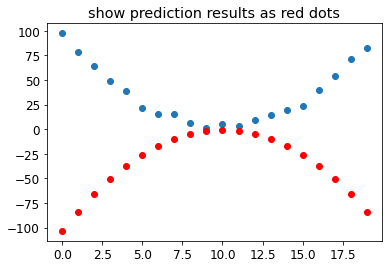

In [ ]:
show_prediction_and_real_results(prediction_result)

由于初始的预测模型中的权重参数值是随机数，所以预测结果跟真实结果之间的差距可能会很大。 

#### 步骤3. 计算当前具体的预测模型的预测结果与真实结果之间的loss函数值

In [ ]:
loss_value = loss_square_root_of_mean_of_square_error(
    prediction_result=prediction_result, 
    real_result=observed_data_speed
)
print(f"{loss_value = }")

loss_value = tensor(70.5369, grad_fn=<MeanBackward0>)


由于我选择的计算loss的统计学方法是均方误差平方根，所以loss函数值是一个大于或等于0的数，是1个数值。它可以比1大，也可以比1小。 

#### 步骤4. 计算当前loss函数值的梯度值

计算的操作是调用loss_value的backward()方法，在神经网络领域中，把计算梯度值的操作叫做'backward'。

而获取梯度值，是取得权重参数parameters.grad属性值。

为什么Loss_value对于parameters的梯度值，自动保存在了parameters的属性中，而不是Loss_value的属性中，我猜测是因为这个梯度值最终要用在更新权重参数parameters数值的操作中。

In [ ]:
loss_value.backward()

In [ ]:
print(f"{parameters.grad = }")

parameters.grad = tensor([-33.5000,  -1.0000])


#### 步骤5. 更新权重参数值

设置学习速率或称更新速率，一般在0到0.1之间。

In [ ]:
learning_rate = 1e-3
# learning_rate = 1e-3
# learning_rate = 1e-4
# learning_rate = 1e-5
# learning_rate = 0.01

In [ ]:
# 令权重参数的数值减去一个‘梯度值’
print(parameters)
parameters.data -= parameters.grad.data * learning_rate
# 是下面代码的简化写法
# parameters.data = parameters.data - parameters.grad.data * learning_rate

# 对权重参数保存的梯度值属性重置为None
parameters.grad = None

# 注意，这个梯度值，实际上是Loss函数值的梯度值，
# 这里是用Loss函数值的梯度值，来变更权重参数值。

tensor([-1.0297, -0.5008], requires_grad=True)


这里需要解释一下，为什么用Loss函数值的梯度值，来变更权重参数值。

Loss函数的定义中，接收的输入参数是预测结果值，而预测结果值是由预测模型接收输入数据值以及权重参数值所求得的，也就是说Loss函数是可以对权重参数求导数的。

我们希望能获得 使Loss函数值最小的 权重参数值，也就是说当权重参数值发生变化时，我们希望这种变化是朝着Loss函数值最小处发展的。

于是就有了gradient descent这样的理论
```
parameter = parameter - gradient
```

例如下图中，在曲线的左侧，parameter处的loss的gradient值是负数，而parameter减去这个gradient负数，刚好能使parameter增大，即右移，那么新的parameter处，loss值就会变小，这就达到我们的期望了。

对于在曲线的右侧，则是，parameter处的loss的gradient值是正数，而parameter减去这个gradient正数，刚好能使parameter减小，即左移，那么新的parameter处，loss值就会变小，这也达到我们的期望了。

总之，都是parameter 减去 gradient，能使得新的parameter处的loss值更小。

![](https://raw.githubusercontent.com/fastai/fastbook/780b76bef3127ce5b64f8230fce60e915a7e0735/images/chapter2_small.svg)

看一下更新权重参数值后的模型的效果 

parameters = tensor([-0.9962, -0.4998], requires_grad=True)
parameters.data = tensor([-0.9962, -0.4998])
parameters.grad = None


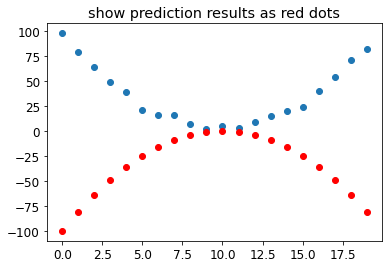

In [ ]:
prediction_result = predict_speed(
    time=observed_data_time,
    parameters=parameters
)
loss_square_root_of_mean_of_square_error(
    prediction_result=prediction_result, 
    real_result=observed_data_speed
)
show_prediction_and_real_results(prediction_result)
print(f"{parameters = }")
print(f"{parameters.data = }")
print(f"{parameters.grad = }")

#### 步骤6. 重复多次上述的学习过程

由于上述对模型的权重参数的更新操作的一系列步骤，需要重复多次，所以把它们写到一个函数里，后面可以写循环体代码多次调用这个函数。 

In [ ]:
def learn_and_adjust_weight_parameters(
        parameters, learning_rate=learning_rate
    ):
    prediction_result = predict_speed(
        time=observed_data_time,
        parameters=parameters
    )
    loss_value = loss_square_root_of_mean_of_square_error(
        prediction_result=prediction_result,
        real_result=observed_data_speed
    )
    loss_value.backward()
    parameters.data -= parameters.grad.data * learning_rate
    parameters.grad = None
    print(f"{loss_value.item() = }")
    return prediction_result,loss_value.item()

In [ ]:
# learning_rate = 0.01
# for i in range(10):
#     learn_and_adjust_weight_parameters(
#         parameters=parameters, 
#         learning_rate=learning_rate
#         # learning_rate=learning_rate
#     )
    

我想把每一个epoch学习后的预测结果与真实结果的作图都给展示出来 

下面我要学习用python plt作多个小图 


[画小图的中文教程](https://blog.csdn.net/fengdu78/article/details/107888652)

plt中的figure与axis
![plt中的figure与axis](https://imgconvert.csdnimg.cn/aHR0cHM6Ly9tbWJpei5xcGljLmNuL21tYml6X3BuZy9nNjRzYmI2RmZtZEpIb0tKSDh6RGljOHBFczhlc2tqYmI0MHJKTEpBQTFzc09ydzVBeWNMdG5HMUxpYXcwSnBBdUljZDN5V2M0RU1kdmtabVM2c0NLYlpBLzY0MA?x-oss-process=image/format,png)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

def learn_and_adjust_weight_parameters(
        parameters, learning_rate=learning_rate
    ):
    prediction_result = predict_speed(
        time=observed_data_time,
        parameters=parameters
    )
    loss_value = loss_square_root_of_mean_of_square_error(
        prediction_result=prediction_result,
        real_result=observed_data_speed
    )
    loss_value.backward()
#     print(f"{parameters.data = }")
#     print(f"{parameters.grad.data = }")
    parameters.data -= parameters.grad.data * learning_rate
    parameters.grad = None
    return prediction_result,loss_value.item()

def train_model_and_show_prediction_results_for_epochs(
        parameters,
        number_of_epoch=10, 
        number_of_columns_of_subplots=4,
        time=observed_data_time,
        observed_data_speed=observed_data_speed
    ):
    number_of_rows_of_subplots = math.ceil(number_of_epoch/number_of_columns_of_subplots) # 10/4 = 3
    # number_of_columns_of_subplots = 4
    # number_of_rows_of_subplots = 3
    height_of_1_row_subplots = 8
    width_of_1_column_subplots = 8
    height_of_all_rows_subplots = height_of_1_row_subplots * number_of_rows_of_subplots
    width_of_all_columns_subplots = width_of_1_column_subplots * number_of_columns_of_subplots
    overall_figsize = (width_of_all_columns_subplots, height_of_all_rows_subplots)
    print(f"{overall_figsize = }")
    figure, axis = plt.subplots(
        number_of_rows_of_subplots,
        number_of_columns_of_subplots,
        figsize=overall_figsize # 第1个数值表示总图的宽度，第2个数值表示总图的高度
    )
    for index_of_subplot in range(number_of_epoch):
        prediction_result,loss_value_item = learn_and_adjust_weight_parameters(
            parameters=parameters, learning_rate=learning_rate
        )
#         print(f"{prediction_result = }")
#         print(f"{loss_value_item = }")
#         0 // 3 = 0
# 0 % 4 = 0
# 3 // 3 =1
        row_index_of_current_subplot = index_of_subplot // number_of_columns_of_subplots # 除法，取商
        column_index_of_current_subplot = index_of_subplot % number_of_columns_of_subplots # 除法，取余数
#         print(f"{index_of_subplot = }")
#         print(f"{number_of_rows_of_subplots = }")
#         print(f"{number_of_columns_of_subplots = }")
#         print(f"{index_of_subplot // number_of_columns_of_subplots = }")
#         print(f"{index_of_subplot % number_of_columns_of_subplots = }")
#         print()
        axis[row_index_of_current_subplot][column_index_of_current_subplot].scatter(time, observed_data_speed)
        axis[row_index_of_current_subplot][column_index_of_current_subplot].scatter(time, to_np(prediction_result), color='red')
        axis[row_index_of_current_subplot][column_index_of_current_subplot].set_title(f"{loss_value_item = }")
        # 把预测模型的权重参数a,b,c的值画到小图中
        axis[row_index_of_current_subplot][column_index_of_current_subplot].annotate(
            parameters.data, xy=(0, 0), xytext=(0, 0),
        )
    plt.tight_layout()
#     plt.title("show prediction results as red dots")

overall_figsize = (32, 200)


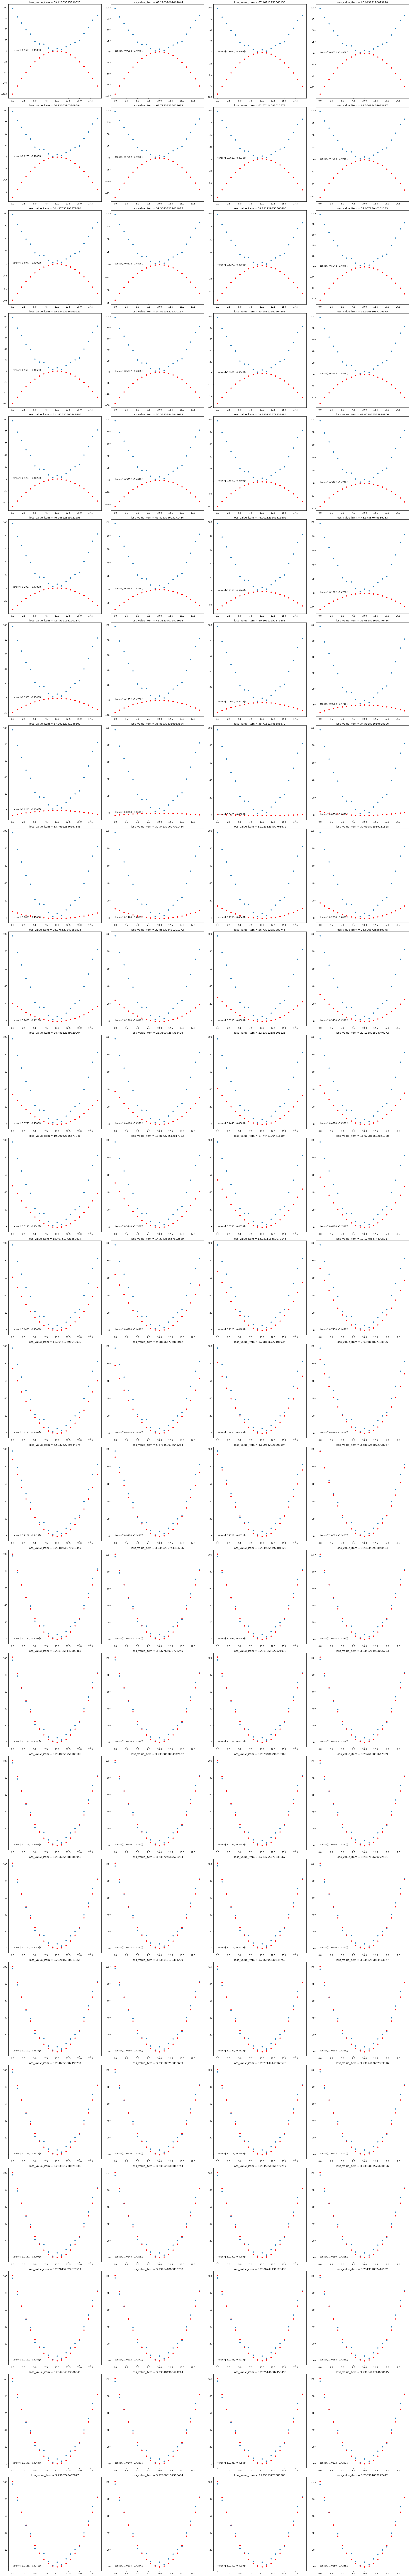

In [ ]:
train_model_and_show_prediction_results_for_epochs(
    parameters=parameters,
        number_of_epoch=100, 
#         time=observed_data_time,
#         observed_data_speed=observed_data_speed
    )

20211003 9:47
我现在要解决的问题是，为什么，我的模型不能拟合出来数据集的曲线？

为什么fastai教程里，训练了10个epoch，就能达到很好的效果？

我能想到最大的区别，就是fastai中生成采样数据的二次函数关系式，跟我的不一样。但这个有影响吗？

后来我想到模型的权重参数，a,b,c，初始值，fastai的跟我的不一样，这个可能是造成差异的最重要的因素。
如果我的权重参数的初始值比较不合适，那么可能会陷入Loss函数的某个局部最小值区域中，而不是全局的最小值区域。

我把learning_rate调整为0.01， 然后把前面的单独写for循环运行10遍训练操作的代码给注释掉。

再把learning_rate调整为1e-5, 这个效果不好，学的很慢。

把learning_rate调整为1e-4, 这个值好像是效果比较好的，但是预测结果还是没有完全接近实际数据曲线。loss值降到23.97,就不再降低了，为什么？

感觉还是陷入了一个局部最优解当中去了。

我的感慨是，合适的learning_rate是最重要的，权重参数的初始值也很重要。前面还有一个，原始的数学式子architecture也很重要。

把learning_rate调整为1e-3，这个值好像是效果比较好的，但是预测结果还是没有完全接近实际数据曲线。loss值降到23.95,就不再降低了。

把learning_rate调整为1e-2，这个效果要差一些，loss值降到140，不再降低。


我发现Loss函数对拟合曲线这个目的不够好。
我试着把Loss函数，写成差异的绝对值的平均值。
learning_rate为1e-3

初始的模型公式也要改一下，使它变得人更容易阅读，检查。
```
y = a*((x-b)**2)+c
```
二次函数曲线的顶点坐标为(b,c),开口朝上还是朝下，由a的正负决定，开口是宽还是窄，由a的绝对值的大小决定。
然后把这些信息作为annotation text，画在图中

20211003 16：43

我在想，是不是，机器学习在训练的过程中，把精力主要画在找最合适的权重参数a上面了，例如求梯度值时，是以a为最重要的目训练权重参数。

现在，我想着，我直接把初始的模型的二次函数的参数a，设成定值，跟我生成采集数据的二次函数中的系数a完全一样，看看这样对权重参数b的训练效果会不会好一些？

预测出来的曲线，二次函数的曲线的对称轴还是没有移到采集数据的对称轴处，为什么？

我下面要试一下，把a和b都固定住，只训练参数c。
然后是把最难搞的参数b给固定住，训练参数a和c

把a和b都固定住，只训练参数c。 然后是把最难搞的参数b给固定住，训练参数a和c。

这种方案下，训练100次epoch，训练效果的变化过程图，真的很漂亮！

所以，这里就涉及一个底层的知识，pytorch究竟是怎么计算梯度值的？为什么会产生对权重参数值的追求的偏向性？ 